Similar to the `seq-pred` but the X-sequence will now represent the sequence of events generated by an online shopper. There will be 3 types of events:

- 0 = product browse
- 1 = carting
- 2 = purchase / convert

An X event at index i will be characterized by the probability-vector ("ProbVec") of the 3 possible actions (0,1,2), defined by the following rules:

```python
if i < L:
    ProbVec = (0.5, 0.5, 0.0)
else if there are at least c cart events (1 values) within a w-day window during over the past L days
    ProbVec = (0.15, 0.15, 0.70)
else:
    ProbVec = (0.5, 0.5, 0.0)
```
The task is to predict whether there will be a Purchase event (2) over the next `f` time-steps. The "Teaching sequence" `Y` will provide this for training.



In [1]:
from rnn import *
from shopgen import *
from tqdm import tqdm_notebook as tn
from tqdm import tqdm, trange

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt



Generate Data First

In [2]:
g = shopgen(carts=3, win=6, infwin=3, future=3)
x, y, py, loss, emp =  g.gen_xy(40)
np.transpose(np.stack([x,y,py]))


array([[ 1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 1.   ,  1.   ,  0.973],
       [ 0.   ,  1.   ,  0.91 ],
       [ 1.   ,  1.   ,  0.973],
       [ 2.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ],
       [ 1.   ,  1.   ,  0.973],
       [ 0.   ,  1.   ,  0.91 ],
       [ 2.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ],
       [ 1.   ,  1.   ,  0.   ],
       [ 0.   ,  1.   ,  0.973],
       [ 2.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ],
       [ 1.   ,  1.   ,  0.   ],
       [ 1

In [3]:
(emp, loss)

(0.6108643020548935, 1.4806700205065244)

In [2]:

# x, y, py, loss, emp = g.gen_xy(500)
# np.transpose(np.stack([x,y,py]))

btrain = g.gen_tensors(nt=200, nb=1000, minlen = 0.3, fill = 'rand', gpu = True, xhot=True)

var_x, var_y, lengths = btrain.x, btrain.y, btrain.lengths

btest = g.gen_tensors(nt=200, nb=1000, minlen = 0.3, fill = 'rand', gpu = True, xhot=True)

xtest, ytest = btest.x, btest.y




In [3]:
(btrain.emp, btrain.loss)


(0.63704081058734241, 2.5176733142788636)

In [ ]:
x = var_x[:, 0, :].squeeze().cpu().numpy()
np.transpose(map(lambda row: np.where(row)[0][0], x))

In [ ]:
y = np.transpose(map(lambda x: int(x), var_y[:, 0, :].squeeze().cpu().numpy()))
y

<IPython.core.display.Javascript object>


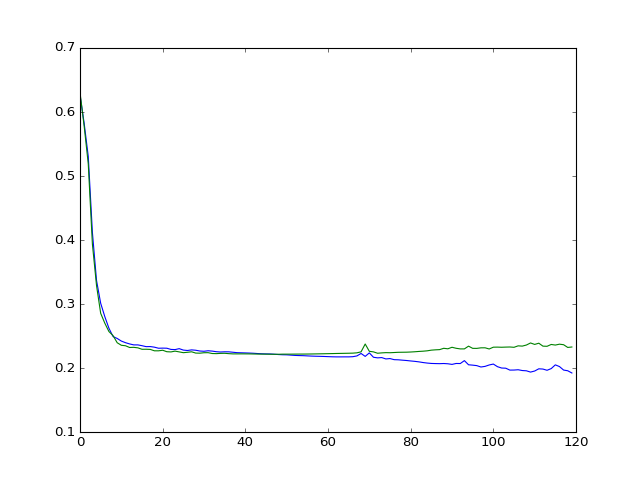

NameError: name 'sklearn' is not defined

In [4]:


# best settings:
#model = RNN(rnn_type ='GRU', nf=2, nh=25, nlay=3, dropout = 0.5)
#model = RNN(rnn_type ='GRU', nf=2, nh=10, nlay=1, dropout = 0.1) # BEST!! final test loss = 0.48
#model = RNN(rnn_type ='LSTM', nf=2, nh=16, nlay=1, dropout = 0.0) # 0.47 !

model = RNN(rnn_type ='GRU', nf=3, nh=50, nlay=1, dropout = 0.0) # best for diff_data !!! use Adam lr = 5e-4



#loss_fn = nn.MSELoss(size_average=True)
loss_fn = nn.BCELoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
#optimizer = optim.Adagrad(model.parameters(), lr = 0.1)
#optimizer = optim.Adam(model.parameters(), lr = 0.7)
#optimizer = optim.RMSprop(model.parameters(), lr = 0.001)
model.zero_grad()



#var_x, var_y, lengths, xtest, ytest, test_lens = make_diff_data(15, 1000, 1, 3, gpu = True)

#var_x, var_y, lengths, xtest, ytest, test_lens = make_r2rt_data(30, 1000, 1, gpu = True, xhot = True)
## manually run model a few iterations 
model.cuda()

bsiz = 100 # mini-batch size
nb = var_x.size()[1]/bsiz  # how many mini-batches per epoch

nepochs = 120
loss = 1.0
#epoch_range = trange(nepochs, desc='Loss', leave=True)
    
points = np.zeros(nepochs) # train losses
val_points = np.zeros(nepochs) # validation losses

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
for p in model.parameters():
    if p.ndimension() < 2:
        nn.init.normal(p)
    else:
        nn.init.xavier_uniform(p)
    
for epoch in range(nepochs):
    for batch in range(nb):
        bStart = batch * bsiz
        bEnd = min(var_x.size()[1], (batch + 1)*bsiz)
        
        hidden = model.init_hidden(bsiz)
        hidden = repackage_hidden(hidden)
        
        model.zero_grad()
        optimizer.zero_grad()
        

        batch_x = var_x[:, bStart : bEnd, :]
        batch_lengths = lengths[bStart : bEnd]
        batch_x_packed = rnn_utils.pack_padded_sequence(Variable(batch_x), batch_lengths)
        y_pred, hidden = model(batch_x_packed, hidden)
                
        batch_y = rnn_utils.pack_padded_sequence(Variable(var_y[:, bStart : bEnd, :]), batch_lengths)
        

        # CAUTION -- y_pred is BATCH-WISE, i.e. b
        # batch 0 for ALL sequences, then
        # batch 2 for ALL sequences, etc.
        # target = var_y.squeeze()[:, bStart:bEnd].contiguous().view(-1, 1)
        loss = loss_fn(y_pred, batch_y.data)
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # tqdm.write('loss = ' + str(loss.data[0]))
    points[epoch] = loss.data[0]  
    ypred_val = model(Variable(xtest), None)[0]
    val_loss = loss_fn(ypred_val, Variable(ytest)).data[0]
    val_points[epoch] = val_loss
    ax.clear()
    ax.plot(points)
    ax.plot(val_points)
    fig.canvas.draw()
#     epoch_range.set_description("Loss %4.3f" % loss.data[0])
#     epoch_range.refresh() # to show immediately the update


p = (ytest.sum()/(ytest*0 + 1).sum())
emp_loss = -p*np.log(p)-(1-p)*np.log(1-p)


ypred = y_pred.data.squeeze().cpu().numpy()
ylabel = batch_y.data.data.cpu().numpy()
auc_train = sklearn.metrics.roc_auc_score(ylabel, ypred)

yt = ytest.squeeze().cpu().numpy().flatten()
ypred_val = model(Variable(xtest), None)[0]
ypv = ypred_val.data.squeeze().cpu().numpy()
auc_val = sklearn.metrics.roc_auc_score(yt, ypv)

print 'emp loss =', emp_loss
print 'val loss = ', val_loss

print 'train auc =', auc_train
print 'val   auc =', auc_val



# print 'y,pred = ', zip(batch_y.data.squeeze()[:ny].data.cpu().numpy(), y_pred.data.squeeze()[:ny].cpu().numpy())


### Use the learned rnn to do some interesting things

1. Create just one sequence and pass it through model, or model.rnn



In [10]:
x, y, py, loss, emp = g.gen_xy(500)
tx = one_hot(t.Tensor(x).view(-1,1,1))
my, _ = model(Variable(tx.cuda()), None)
my = np.round(my.data.cpu().numpy().flatten(),2)
np.transpose(np.stack([x,y,py,my]))






array([[ 1.        ,  0.        ,  0.        ,  0.5       ],
       [ 0.        ,  0.        ,  0.        ,  0.52999997],
       [ 0.        ,  0.        ,  0.        ,  0.54000002],
       ..., 
       [ 1.        ,  0.        ,  0.        ,  0.62      ],
       [ 1.        ,  0.        ,  0.        ,  0.95999998],
       [ 0.        ,  0.        ,  0.973     ,  0.99000001]])

In [11]:
import sklearn.metrics
sklearn.metrics.roc_auc_score(y, my)

# tx = one_hot(t.Tensor(x).view(-1,1,1))
# model(Variable(tx.cuda()), None)
#xtest


0.97022091619877215

In [17]:
yt = ytest.squeeze().cpu().numpy().flatten()
ypred_val = model(Variable(xtest), None)[0]
ypv = ypred_val.data.squeeze().cpu().numpy()
sklearn.metrics.roc_auc_score(yt, ypv)


0.96199512971469825

In [25]:

ypred = y_pred.data.squeeze().cpu().numpy()
ylabel = batch_y.data.data.cpu().numpy()
sklearn.metrics.roc_auc_score(ylabel, ypred)

0.96890071552128643

In [ ]:
var_y[:15, 0,0]
